# Integrating a System 

The famous Michaleis-Menten equation makes some big assumptions. And it is easy to design an experiment so that the equation works very well. One important idea is that the concentration of enzyme must be small compared to the concentrationn of the substrate. Then the free substrate concentration will be very close to the total substrate concentration at all times.

But what if we want to model the equation more fully? Let us include the effects of the enzyme on substrate concentration. We will still assume the reaction is ireversible and we state the following model scheme for the reaction.

$$ E + S\rightleftharpoons ES \rightarrow P$$

And could be expressed with the following reactions.

$$E + S \xrightarrow{k_1} ES \\ 
ES \xrightarrow{k_{-1}}  E + S\\
ES \xrightarrow{k_{cat}} P + E $$

Now let us integrate all three of these reaction together as a system that describes MM kinetics.

In this notebook will not use analytical methods but instead use the numerical algorithms encapsulated the Python tools. We will use `scipy.integration.solve_ivp()`.

## Using *solve_ivp*

The code below calculates the instantaneous rate of change for each reactant, intermediate and product in the Michaelis-Menten system and then integrates the whole system using numerical methods. Using the reaction scheme outlined above we can define the following rates at a given moment in time.

$$\frac{d}{dt}[S] = -(k_1 [S][E])+(k_{-1}[ES])$$
$$ \frac{d}{dt}[E] = -(k_1 [S][E])+(k_{-1}[ES])+(k_{cat}  [ES])$$
$$ \frac{d}{dt}[ES] = (k_1 [S][E])-(k_{cat}[ES])-(k_{-1}  [ES])$$   
$$ \frac{d}{dt}[P] = k_{cat} [ES]$$

It is possible to integrate the differential equations for all four species in the scheme. But numeric integration is much simpler to set up in *Python*. 

Observe the code below. We create a function tha calculates the instantaneous rate of change for all four species from known concentrations. We will then send this function into the numeric integration tool of *SciPy*.

Km: 0.00505 M
Vmax: 6000.00 uM min
kcat/Km: 1.98e+04


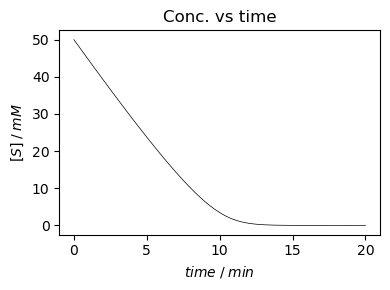

In [1]:
#######################
### import packages 
#######################

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

############################################
### Create a function that describes the 
### system of differential equations. 
############################################

def rates(t, c, K1, K_1, Kcat):  

    S = c[0]; E = c[1]; ES = c[2]           ### assign initial conc. from input list c

    ds_dt = -K1 * c[0] * c[1] + K_1 * c[2]    ### rates of each reaction step with give concentration in list c
    de_dt = -K1 * c[0] * c[1] + K_1 * c[2] + Kcat * c[2]
    des_dt = K1 * c[0] * c[1] - K_1 * c[2] - Kcat * c[2]
    dp_dt =  Kcat * c[2]

    return [ds_dt, de_dt, des_dt, dp_dt]


############################################
### Parameters and experimental conditions
############################################

k1 = 2E6          ### Values for kinetic parameters
k_1 = 1E4
kcat = 1E2

E_conc = 1E-6     ### Experimenatal condition
S_conc = 0.05
      
time_end = 1200   ### The end time
n_points = 12000   ### number of points - increase if needed

#########################################
### Create series of time points      
#########################################

dt = time_end / n_points           ### time step, delta t
t_line = np.arange(0, time_end+dt, dt) ### time vector (list of time points)
num = len(t_line)

#########################################
### Report the Michaelis-Menten parameters      
#########################################

KM_model = (k_1 + kcat)/k1         ### Calculate Briggs-Haldane Km value

print(f"Km: {KM_model:0.5f} M")    ### Print out calculated MM parameters
print(f"Vmax: {kcat*E_conc*1E6*60:0.2f} uM min")
print(f"kcat/Km: {kcat/KM_model:0.2e}")

#########################################
### Integrate the system of differential equations      
#########################################

initial = [S_conc, E_conc, 0, 0]      ### Set list of initial values (S, E, ES, P)

int = solve_ivp(rates,                ### the function being integrated. 
                [0, time_end],        ### start and endpoint of integration
                initial,              ### initial values
                method = "Radau",     ### 'RK45', 'RK23', 'LSODA', 'DOP853', 'Radau', 'BDF'
                t_eval = t_line,      ### time points at which to calculate values
                first_step = 1e-5,    ### take a very small first step. the initial rate is much faster than the average slope.
                args = [k1,k_1,kcat]  ### values to send to function after t and c
                )

#########################################
### Extract the results from the returned data object      
#########################################

time = int.t        ### solve_inp() returns and array for time indexed as 't'
yarray = int.y      ### Also retruns and array of calculated y values.
                    ###  if more than one value returned from function we will
                    ###  get a array of arrays for each value
yarray = yarray[0]  ### The first array in the y-array is for S: substrate

##################################################################################
### Plot the results
##################################################################################

plt.rcdefaults()                    ### resets the plot defaults so we always start in the same place
#plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))  

                    ### set x and y values for plot code below
x = time/60         ### convert time from seconds to minutes
y = yarray*1000     ### convert conc from M to mM

#########################################
### Plot the line using the x_fit, y_fit points
#########################################

ax.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )

#########################################
### Add more style
#########################################
        
ax.set(ylabel=r"$[S]\;/\;mM $", 
        xlabel=r"$time\; /\; min$",
        title = "Conc. vs time",
        xlim=[None, None],      
        ylim=[None, None])


fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig("plot.pdf")    # use this to save the figure in PDF format
plt.show()                 # output the combined four plots



## Comparing Results

In the previous notebook we integtrated the Michaelis-Menten equation both analytically and numerically. Here we are integrating the whole system of differential equations that describes the enzyme kinetics of a Michaelis-Menten enzyme kinetics scheme. There will be differences Here. The enzyme will alter the concentration of free substrate in solution when some of the substrate is sequestered in the ES complex.

If enzyme concentration is much less that substrate the difference will be small. The code below will plot both the result from the numerically integrated system of differential equations and the result from the analytical integtration of the Michaelis-Menten equation. Both sets of data will be plotted on top of each other with one in red andthen the other in black on top. Do you see any red? The two data sets are accurate within the width of the plot line.

Then I will plot the % difference between the two data sets and also the absolute difference. We see the sudden drop in the concentration of substrate revealed in the difference plot. Because the concentration of enzyme is so small, the difference is unimportant.

The integrated rate law for the MM equation


Eq(S_t, K_M*LambertW(S_0*exp((S_0 - V_{max}*t)/K_M)/K_M))

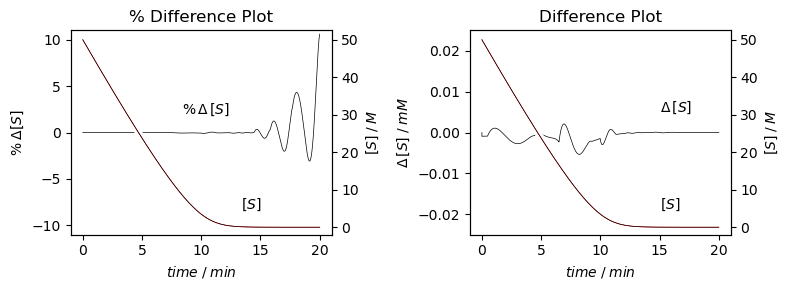

In [2]:
#########################################
### Stolen code to created analytically integrated function for S vs, t
#########################################

import sympy as sym
from matplotlib import pyplot as plt
import numpy as np

##########################
### Set up equation 
##########################

t = sym.symbols('t')           ### create x as a 'symbol', not a variable
Vmax = sym.symbols('V_{max}')  ### create k as a 'symbol'
St = sym.symbols('S_t')        ### create At as a 'symbol'
S0 = sym.symbols('S_0')        ### create A0 as a 'symbol'
KM = sym.symbols('K_M')

xt = sym.Function('x_t')       ### create x as a 'function', not a variable

lhs = sym.Derivative(-St, t)   ### Using Derivative function to get differential of A(t) w.r.t. t
rhs = Vmax*(St/(KM+St))

diffeq = sym.Eq(lhs, rhs)                   ### create a sympy equation
diffeq = diffeq.subs({St: (S0 - xt(t))})    ### Substitute the term with S0-x

##########################
### Solve the differential equation 
##########################

res = sym.dsolve(diffeq, ics={xt(0): 0})    ### Solve the differential equation. Initial condition is x(t) = 0 when t = 0

##########################
### Clean up algebra 
##########################

eq = res.subs(xt(t), S0-St)            ### substitute x for So - St
eq = sym.simplify(eq)                  ### Simplify the result
eq = sym.Eq(eq.lhs - S0, eq.rhs - S0)  ### Subtract S0 from both sides of the equation
eq = sym.Eq(-eq.lhs, -eq.rhs)          ### take the negative of both sides of the equation 

##########################
### Display the final form of equation 
##########################

print("The integrated rate law for the MM equation")
display(eq)                            ### display the equation used to create the S vs. t data              

##############################################################################

##########################
### create function from equation
##########################

f = sym.lambdify([t, S0, KM, Vmax], eq.rhs)   ### create function in terms of t, S0, KM and Vmax

##########################
### Set up parameters
##########################

#E_conc = 1e-6               ### commented out. using E_conc set in the first code block above
KM_value = KM_model          ### set KM value to KM calculated using parameters in first code block above
kcat_value = kcat            ### set Vmax value to Vmax calculated using parameters in first code block above
S0_value = S_conc            ### set initial substrate concentration value to value from first code block
Vmax_value = E_conc * kcat_value

##########################
### calculate x and y data
##########################
                                                ### time comes from the first code block above
s = f(time, S0_value, KM_value, Vmax_value)     ### Calculate substrate conc according to the function
s = np.real(s)                                  ### the Lambert function produces imaginary numbers. Use on the real component
s = s * 1000                                    ### convert M to mM

c =  yarray                                     ### numerical result from the top code block
c = c *1000                                     ### convert M to mM

######################################################################################
### Make a plot of the difference bewteen the two sets of results
######################################################################################

plt.rcdefaults()                    ### resets the plot defaults so we always start in the same place
#plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))  

ax0 = ax[0]     ### create names for the two axes in the ax array
ax1 = ax[1]

######################################################################################
### Left plot with %diff vs t (ax0) and s vs t (ax) stacked on top of each other
######################################################################################

##########################
### %diff vs t (ax0)
##########################

x = time / 60          ###
y = 100 * (c-s)/c   ### Percent error

ax0.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )
        
ax0.set(ylabel=r"$\% \; \Delta [S]\; $", 
        xlabel=r"$time\; /\; min$",
        title = "% Difference Plot",
        xlim=[None, None],      
        ylim=[-11, 11])

ax0.text(500/60, 2.0, "$\%\, \Delta \,[S]$")   ### label the line in the plot

##########################
### s vs t (ax0)
##########################

ax2 = ax0.twinx()

ax2.plot(x, c,                      ### Plot a thick white line under the data line
        linestyle = '-',            ### use a line between points
        linewidth='5',              ### make the line thin
        color = 'white',            ### the line is black
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)

ax2.plot(x, c,                      ### plot a thin black line as the data of the plot
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'red',              ### the line is black
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)

ax2.plot(x, s,                      ### plot a thin black line as the data of the plot
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)

 
ax2.text(800/60,5,"$[S]$")         ### label the line in the plot

ax2.set(ylabel=r"$[S]\; / \;M$", 
        xlim=[None, None],      
        ylim=[-2, None])


######################################################################################
### Right plot with diff vs t (ax1) and s vs t (ax3) stacked on top of each other
######################################################################################

##########################
### %diff vs t (ax1)
##########################

x = time / 60
y = (c-s)

#########################################
### Plot the line using the x_fit, y_fit points
#########################################

ax1.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 1                  ### everything is in layer 0 (the bottom layer in this case)
        )

ax1.text(900/60,0.005,"$\Delta \,[S]$")

#########################################
### Add more style
#########################################
        

ax1.set(ylabel=r"$\Delta \,[S]\; / \; mM$", 
        xlabel=r"$time\; /\; min$",
        title = "Difference Plot",
        xlim=[None, None],      
        ylim=[-0.025, 0.025])


ax3 = ax1.twinx()

ax3.plot(x, c,
        linestyle = '-',    ### use a line between points
        linewidth='5',      ### make the line thick
        color = 'white',    ### the line is black
        zorder = 0 )        ### everything is in layer 0 (the bottom layer in this case)

ax3.plot(x, s,
        linestyle = '-',    ### use a line between points
        linewidth='0.5',    ### make the line thin
        color = 'red',      ### the line is red
        zorder = 0 )        ### everything is in layer 0 (the bottom layer in this case)

ax3.plot(x, c,
        linestyle = '-',    ### use a line between points
        linewidth='0.5',    ### make the line thin
        color = 'black',    ### the line is black
        zorder = 0 )        ### everything is in layer 0 (the bottom layer in this case)

ax3.text(900/60,5,"$[S]$")

ax3.set(ylabel=r"$[S]\; / \;M$", 
        xlim=[None, None],      
        ylim=[-2, None])




fig.tight_layout()  # otherwise the right y-label is slightly clipped
#########################################
### Output the plot
#########################################

plt.savefig("plot.pdf")          ### export the plot as this
plt.show()                       ### display the plot in this notebook



## Comparing First Moments

The main difference between the Michaelis-Menten equation and the true kinetic behaviour is the initial association of enzyme with substrate. The enzyme will quickly form the ES complex in equilibrium and that will result in a small decrease in subtrate concentration. 

In the previous notebook we paired the analytical and numerical integrations of the MM equation. In that case we were comparing different methods of integbrating the same equation. In this notebook we are comparing two different systems: the simplified MM equation and the system of rate laws from which it was derived.

In the plots above we plotted the analytically integrated MM equation and the numerically integrated system of differential equations. We can barely see the small difference that including the effect of ES complex formation has on the calculated concentration of substrate near time zeroin the difference plot (look for that tiney sharp drop at the start.)

In the code below I will plot the very beginning of the reaction for both the numerical solution to the system of differential equations and the exact analytical solution for the Michaelis-Menten equation. The MM equation assumes that the formation of the ES comples will not affect substrate concentration whereas the integration of the rate law system will show that effect. This code is almost a complete duplicate of the code above. I changed time ranges and numbers of points to acheive the high resolution needed to capture this fast initial change.


Km: 0.00505 M
Vmax: 6000.00 uM min
kcat/Km: 1.98e+04
The integrated rate law for the MM equation


Eq(S_t, K_M*LambertW(S_0*exp((S_0 - V_{max}*t)/K_M)/K_M))

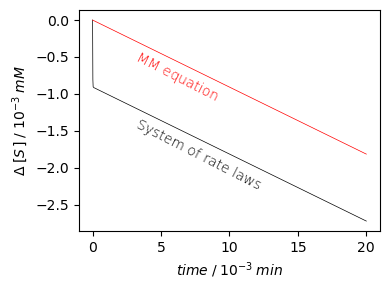

In [3]:
#########################################
### Stolen code to created analytically integrated function for S vs, t
#########################################

import sympy as sym
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp



############################################
### Create a function that describes the 
### system of differential equations. 
############################################

def rates(t, c, K1, K_1, Kcat):  

    S = c[0]; E = c[1]; ES = c[2]           ### assign initial conc. from input list c

    ds_dt = -K1 * c[0] * c[1] + K_1 * c[2]    ### rates of each reaction step with give concentration in list c
    de_dt = -K1 * c[0] * c[1] + K_1 * c[2] + Kcat * c[2]
    des_dt = K1 * c[0] * c[1] - K_1 * c[2] - Kcat * c[2]
    dp_dt =  Kcat * c[2]

    return [ds_dt, de_dt, des_dt, dp_dt]


############################################
### Parameters and experimental conditions
############################################

k1 = 2E6          ### Values for kinetic parameters
k_1 = 1E4
kcat = 1E2

E_conc = 1E-6     ### Experimenatal condition
S_conc = 0.05

#########################################
### HERE! I CHANGED THE TIME RANGE.      
#########################################

time_end = 0.02   ### The end time
n_points = 1000   ### number of points - increase if needed

#########################################
### Create series of time points      
#########################################

dt = time_end / n_points           ### time step, delta t
t_line = np.arange(0, time_end+dt, dt) ### time vector (list of time points)
num = len(t_line)

#########################################
### Report the Michaelis-Menten parameters      
#########################################

KM_model = (k_1 + kcat)/k1         ### Calculate Briggs-Haldane Km value

print(f"Km: {KM_model:0.5f} M")    ### Print out calculated MM parameters
print(f"Vmax: {kcat*E_conc*1E6*60:0.2f} uM min")
print(f"kcat/Km: {kcat/KM_model:0.2e}")

#########################################
### Integrate the system of differential equations      
#########################################

initial = [S_conc, E_conc, 0, 0]      ### Set list of initial values (S, E, ES, P)

int = solve_ivp(rates,                ### the function being integrated. 
                [0, time_end],        ### start and endpoint of integration
                initial,              ### initial values
                method = "Radau",     ### 'RK45', 'RK23', 'LSODA', 'DOP853', 'Radau', 'BDF'
                t_eval = t_line,      ### time points at which to calculate values
                first_step = 1e-5,    ### take a very small first step. the initial rate is much faster than the average slope.
                args = [k1,k_1,kcat]  ### values to send to function after t and c
                )

#########################################
### Extract the results from the returned data object      
#########################################

time = int.t        ### solve_inp() returns and array for time indexed as 't'
yarray = int.y      ### Also retruns and array of calculated y values.
                    ###  if more than one value returned from function we will
                    ###  get a array of arrays for each value
yarray = yarray[0]  ### The first array in the y-array is for S: substrate


##########################
### Set up equation 
##########################

t = sym.symbols('t')           ### create x as a 'symbol', not a variable
Vmax = sym.symbols('V_{max}')  ### create k as a 'symbol'
St = sym.symbols('S_t')        ### create At as a 'symbol'
S0 = sym.symbols('S_0')        ### create A0 as a 'symbol'
KM = sym.symbols('K_M')

xt = sym.Function('x_t')       ### create x as a 'function', not a variable

lhs = sym.Derivative(-St, t)   ### Using Derivative function to get differential of A(t) w.r.t. t
rhs = Vmax*(St/(KM+St))

diffeq = sym.Eq(lhs, rhs)                   ### create a sympy equation
diffeq = diffeq.subs({St: (S0 - xt(t))})    ### Substitute the term with S0-x

##########################
### Solve the differential equation 
##########################

res = sym.dsolve(diffeq, ics={xt(0): 0})    ### Solve the differential equation. Initial condition is x(t) = 0 when t = 0

##########################
### Clean up algebra 
##########################

eq = res.subs(xt(t), S0-St)            ### substitute x for So - St
eq = sym.simplify(eq)                  ### Simplify the result
eq = sym.Eq(eq.lhs - S0, eq.rhs - S0)  ### Subtract S0 from both sides of the equation
eq = sym.Eq(-eq.lhs, -eq.rhs)          ### take the negative of both sides of the equation 

##########################
### Display the final form of equation 
##########################

print("The integrated rate law for the MM equation")
display(eq)                            ### display the equation used to create the S vs. t data              

##############################################################################

##########################
### create function from equation
##########################

f = sym.lambdify([t, S0, KM, Vmax], eq.rhs)   ### create function in terms of t, S0, KM and Vmax

##########################
### Set up parameters
##########################

#E_conc = 1e-6               ### commented out. using E_conc set in the first code block above
KM_value = KM_model          ### set KM value to KM calculated using parameters in first code block above
kcat_value = kcat            ### set Vmax value to Vmax calculated using parameters in first code block above
S0_value = S_conc            ### set initial substrate concentration value to value from first code block
Vmax_value = E_conc * kcat_value

##########################
### calculate x and y data
##########################
                                                ### time comes from the first code block above
s = f(time, S0_value, KM_value, Vmax_value)     ### Calculate substrate conc according to the function
s = np.real(s)                                  ### the Lambert function produces imaginary numbers. Use on the real component
s = (s - 0.05) * 1e6                                 ### convert M to mM

c =  yarray                                     ### numerical result from the top code block
c = (c  - 0.05) * 1e6                                   ### convert M to mM

x = time * 1e3

######################################################################################
### Make a plot of the difference bewteen the two sets of results
######################################################################################

plt.rcdefaults()                    ### resets the plot defaults so we always start in the same place
#plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))  

##########################
### s vs t (ax0)
##########################

ax.plot(x, c,                      ### Plot a thick white line under the data line
        linestyle = '-',            ### use a line between points
        linewidth='5',              ### make the line thin
        color = 'white',            ### the line is black
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)

ax.plot(x, c,                      ### plot a thin black line as the data of the plot
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',              ### the line is black
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)

ax.plot(x, s,                      ### plot a thin black line as the data of the plot
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'red',            ### the line is black
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)


ax.set(ylabel=r"$\Delta \;[S\,]\; / \;10^{-3}\; mM$", 
        xlabel=r"$time\; /\;10^{-3}\; min$",
#        title = "Plot at Time = 0",
        xlim=[None, None],      
        ylim=[None, None])

ax.text(3,-2.3,"System of rate laws", 
         rotation = -27,
         color = 'black',
         fontweight = 'light')         ### label the line in the plot

ax.text(3,-1.1,"MM equation", 
         rotation = -27,
         color = 'red',
         fontweight = 'light')         ### label the line in the plot




fig.tight_layout()  # otherwise the right y-label is slightly clipped
#########################################
### Output the plot
#########################################

plt.savefig("plot.pdf")          ### export the plot as this
plt.show()                       ### display the plot in this notebook



### Observations
We see in the plots that the MM equation begins as if the ES complex formation was instantaneous and also has no effect of substrate oncenbtration (recall that we assumed that $[E] \ll [S]$ when we derived it.)

The numerically integrated system of rate laws does reveal the initial fast association of enzyme and substrate. At high substrate concentrations we will have near saturation of the enzyme and so see an amount of substrate almost equal to enzyme amount absorbed in a raid drop before we reach a steady state (recall that we used the steady-state assumpotion in deriving the MM equation - but we ignored the time needed to reach that steady state.)

The difference between the two lines is about 1 $\mu \!M$ (the concentration of the enzyme) out of 50 $mM$ (the initial substrate conc.) That is an error of $0.002 \; \%$.  Typical enzyme concentrations in MM experiments are in the micromolar to nanomolar range. So if our substrate in in the millimolar range we will never be able to detect a difference between the MM equation and the true behaviour of the system. 

## Conclusion

The power of numerical integration is demonstrated here. We were able to plot the concentration of substrate vs. time by integrating a system of differential rate equations (rate laws). We had to do no math. We avoided real calculus and the required skill to reach the analytical solution.

We also showed that the integration of the MM equation itself is completely satisfactory when enzyme concentration is very small.